# ScEpiTools tutorial

The example analysis is implemented by **scEpiEnsemble**.  
The example data consist in ~3000 cells of human PBMCs. Cells were FAC sorted thus providing a ground truth for cell type identification. The data was produces by [Buenrostro et al. 2018](https://pubmed.ncbi.nlm.nih.gov/29706549/).  
The data can be downloaded from [here](https://www.dropbox.com/s/cwlaaxl70t27tb2/data_tutorial_buenrostro.tar.gz?dl=0).

# 1 Initialization
First import EpiScanpy, Scanpy, Anndata, and some other packages we will be using for analyzing PBMCs.

In [1]:
import os
import numpy as np
import pandas as pd
import scipy
from sklearn import metrics

import anndata as ad
import scanpy as sc
import episcanpy.api as epi

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

sc.settings.set_figure_params(dpi=80, color_map='gist_earth')

# 2 Load the data
The first step of analysis is to load the cell-by-feature matrix as an AnnData object. The matrix is analogous to the gene expression count matrix used to analyze single-cell RNA-seq. However, instead of genes, each row of the matrix represents a region of the genome (a peak/windows), that is predicted to represent a region of open chromatin. ScEpiTools will provide a task-specific ID after uploading the file.  
  
Internal parameters:   
task_id - The only identifier of each task.  

User-defined parameters:  
Input_file - The name of the input file you want to load. We. Default: 'Example.h5ad'.  
Cell_type_key - The key indicating the cell type of each cell stored in observation data frame. If cell type annotation is not provided, input 'None' for this parameter. Default: 'cell_type'.

In [2]:
task_id = 'Example'

inputpath = "./%s/" % task_id
outputpath = "./%s/" % task_id
path_anno = "./%s/scEpiEnsemble_data/" % task_id

We start by creating a Anndata object. scEpiEnsemble uses a .h5ad-format file as input.  

In [3]:
Input_file = task_id + ".h5ad"
Cell_type_key = "cell_type"

In [4]:
def load_data(Input_file):
    file_type = Input_file.split('.')[-1]
    if file_type == 'h5ad':
        adata = ad.read(inputpath + Input_file)
        adata.X = scipy.sparse.csr_matrix(adata.X)
    else:
        print("Input error!")
    return adata

In [5]:
adata = load_data(Input_file)
if Cell_type_key=="None" or Cell_type_key not in adata.obs:
    Cell_type_key = None
print(adata)

AnnData object with n_obs × n_vars = 2034 × 491436
    obs: 'batch', 'cell_name', 'cell_type'


In [6]:
# display information stored in adata.obs
print(adata.obs)

                                               batch  \
BM1077-MPP-Frozen-160105-1                         0   
singles-20160726-scATAC-BM1137-GMP3high-HYC-88     0   
singles-160808-scATAC-BM1137-GMP2mid-LS-65         0   
singles-BM0828-LMPP-frozen-151105-20               0   
singles-160819-BM1137-CMP-LS-95                    0   
...                                              ...   
BM1077-LMPP-Frozen-160107-40                       1   
BM1077-MPP-Frozen-160105-74                        1   
singles-BM1214-GMP-160421-9                        1   
singles-BM0828-LMPP-frozen-151105-62               1   
singles-BM0828-MEP-160420-43                       1   

                                                                                     cell_name  \
BM1077-MPP-Frozen-160105-1                                          BM1077-MPP-Frozen-160105-1   
singles-20160726-scATAC-BM1137-GMP3high-HYC-88  singles-20160726-scATAC-BM1137-GMP3high-HYC-88   
singles-160808-scATAC-BM1137-GMP2

In [7]:
# checking the variable names (bulk peaks coordinates)
print(adata.var_names)

Index(['chr1_10279_10779', 'chr1_13252_13752', 'chr1_16019_16519',
       'chr1_29026_29526', 'chr1_96364_96864', 'chr1_115440_115940',
       'chr1_237535_238035', 'chr1_240811_241311', 'chr1_540469_540969',
       'chr1_713909_714409',
       ...
       'chrX_154822578_154823078', 'chrX_154840821_154841321',
       'chrX_154841449_154841949', 'chrX_154841956_154842456',
       'chrX_154842517_154843017', 'chrX_154862057_154862557',
       'chrX_154870909_154871409', 'chrX_154880741_154881241',
       'chrX_154891824_154892324', 'chrX_154896342_154896842'],
      dtype='object', name='index', length=491436)


# 3 Preprocessing
Next we perform some useful per-cell or per-feature QC metrics.

## 3.1 Binarization
One of the special characteristics of Single-cell chromatin accessibility sequencing data is its close-to-binary nature. Sometimes we will convert the count matrix of fragments/reads to binary.  

User-defined parameters:  
Binarization - Whether to convert the count matrix into a binary matrix. Default: False.  

In [8]:
Binarization = True
if Binarization:
    epi.pp.binarize(adata)
    print(adata)

AnnData object with n_obs × n_vars = 2034 × 491436
    obs: 'batch', 'cell_name', 'cell_type'


## 3.2 Quality controls

### 3.2.1 Remove empty features or barcodes
In the first time of quality control, scEpiTools removes any potential empty features or barcodes.

In [9]:
epi.pp.filter_cells(adata, min_features=1)
epi.pp.filter_features(adata, min_cells=1)
print(adata)

AnnData object with n_obs × n_vars = 2034 × 467226
    obs: 'batch', 'cell_name', 'cell_type', 'nb_features'
    var: 'n_cells'


### 3.2.2 QC plots before filtering

In [10]:
adata.obs['log_nb_features'] = [np.log10(x) for x in adata.obs['nb_features']]
print(adata)

AnnData object with n_obs × n_vars = 2034 × 467226
    obs: 'batch', 'cell_name', 'cell_type', 'nb_features', 'log_nb_features'
    var: 'n_cells'


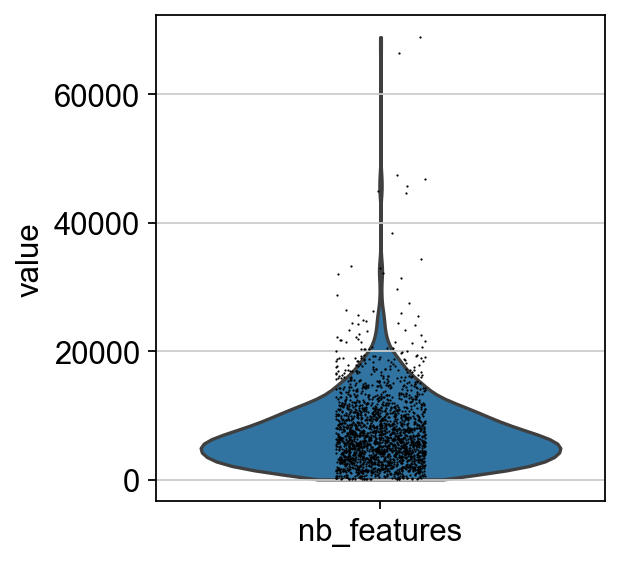

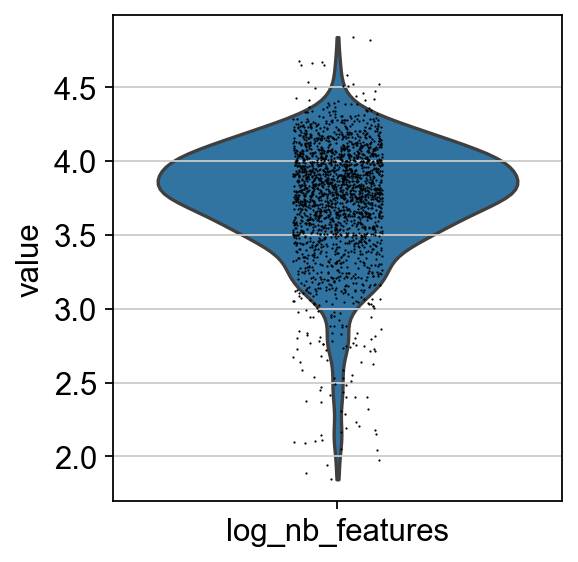

In [11]:
epi.pl.violin(adata, ['nb_features'])
epi.pl.violin(adata, ['log_nb_features'])

### 3.2.3 Filter the cells and peaks based on the QC plots
User-defined parameters:  
Minimum_peaks - Minimum number (integer) or ratio (float) of peaks required for a cell to pass filtering. Default: 1000.  
Minimum_cells - Minimum number (integer) or ratio (float) of cells required for a peak to pass filtering. Default: 20.  

Histogram of the number of open features (in the case of ATAC-seq data) per cell.

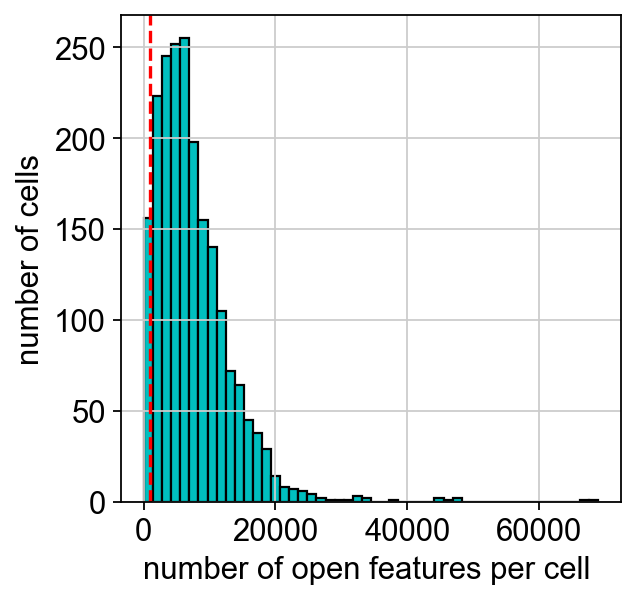

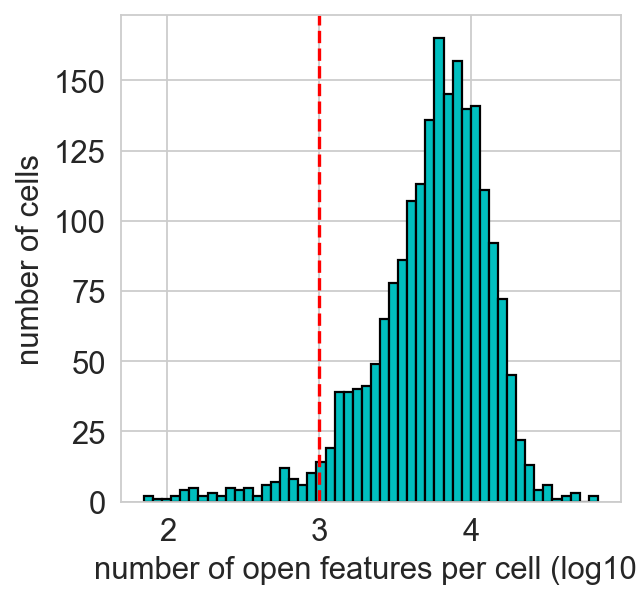

In [12]:
Minimum_peaks = 1000
if type(Minimum_peaks) == float:
    Minimum_peaks = np.ceil(Minimum_peaks*adata.shape[1])

epi.pp.coverage_cells(adata, binary=True, log=False, bins=50, threshold=Minimum_peaks)
epi.pp.coverage_cells(adata, binary=True, log=10, bins=50, threshold=Minimum_peaks)

Display how often a feature is measured as open (for ATAC-seq). Distribution of the feature commoness in cells.

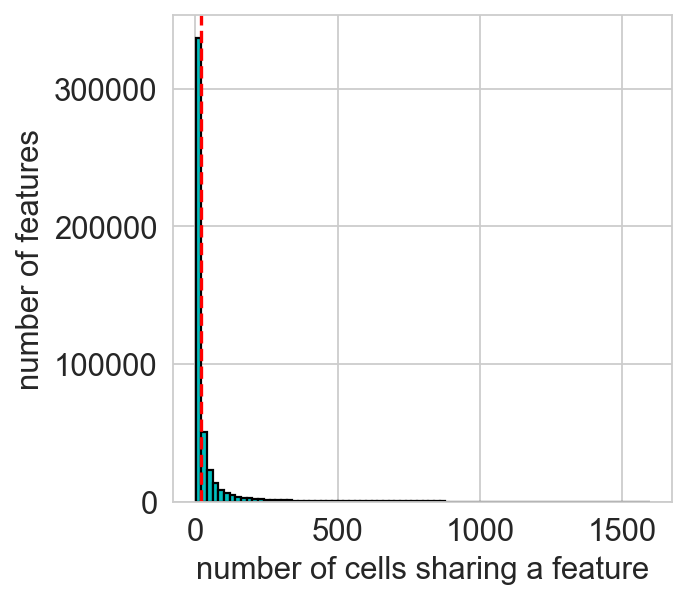

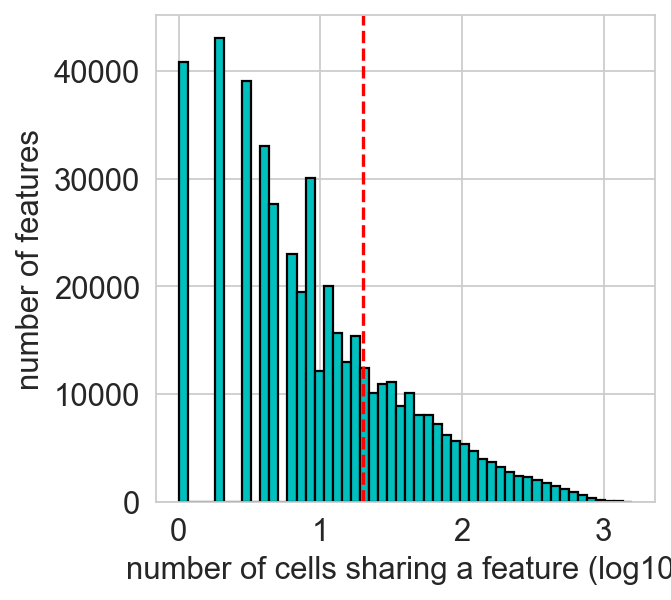

In [13]:
Minimum_cells = 20
if type(Minimum_cells) == float:
    Minimum_cells = np.ceil(Minimum_cells*adata.shape[0])

epi.pp.coverage_features(adata, binary=True, log=False, threshold=Minimum_cells)
epi.pp.coverage_features(adata, binary=True, log=True, threshold=Minimum_cells)

Filter cell outliers based on counts and only keep cells with at least min_peaks counts.

In [14]:
epi.pp.filter_cells(adata, min_features=Minimum_peaks)
print(adata)

AnnData object with n_obs × n_vars = 1945 × 467226
    obs: 'batch', 'cell_name', 'cell_type', 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness'


Filter features based on number of cells and keep features that are expressed in at least min_cells cells.

In [15]:
epi.pp.filter_features(adata, min_cells=Minimum_cells)
print(adata)

AnnData object with n_obs × n_vars = 1945 × 134919
    obs: 'batch', 'cell_name', 'cell_type', 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness'


### 3.2.4 QC plots after filtering

Histogram of the number of open features (in the case of ATAC-seq data) per cell.

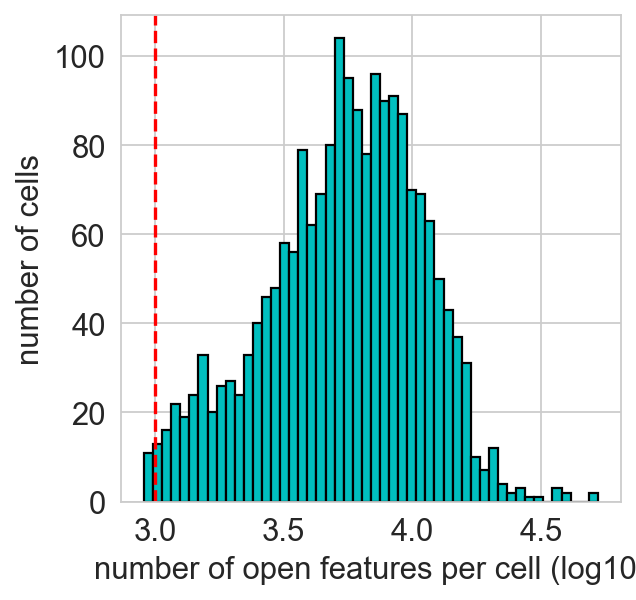

In [16]:
epi.pp.coverage_cells(adata, binary=True, log='log10', bins=50, threshold=Minimum_peaks)

Display how often a feature is measured as open (for ATAC-seq). Distribution of the feature commoness in cells.

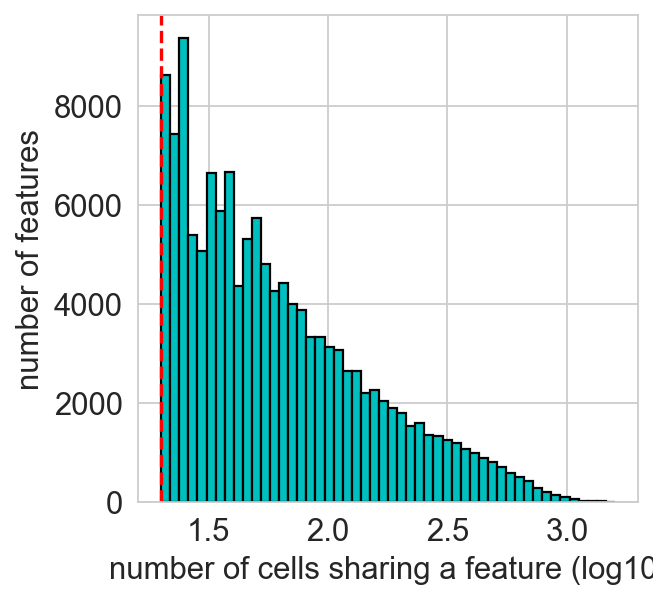

In [17]:
epi.pp.coverage_features(adata, binary=True, log='log10', bins=50, threshold=Minimum_cells)

## 3.3 Term frequency–inverse document frequency
Automatically computes Term frequency–inverse document frequency.  

User-defined parameters:  
TFIDF - Whether to calculate the TFIDF for the dataset. Default: True.

In [18]:
def cal_tfidf(adata):
    adata.X = adata.X / np.sum(adata.X,axis=1)
    adata.X = adata.X / np.sum(adata.X,axis=0)
    adata.X = np.log(1 + 1e4 * adata.X.shape[0] * adata.X)
    adata.X = scipy.sparse.csr_matrix(adata.X)
    return adata

In [19]:
adata.raw = adata

In [20]:
TFIDF = True
if TFIDF:
    adata = cal_tfidf(adata)
    print(adata)

AnnData object with n_obs × n_vars = 1945 × 134919
    obs: 'batch', 'cell_name', 'cell_type', 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness'


## 3.4 Normalization
Save the the normalized matrix in a layer of the Anndata.  

User-defined parameters:  
Normalization - Whether to normalize the dataset. Default: True.

In [21]:
Normalization = True
if Normalization:
    sc.pp.normalize_total(adata)
    adata.layers['normalised'] = adata.X.copy()
    print(adata)

AnnData object with n_obs × n_vars = 1945 × 134919
    obs: 'batch', 'cell_name', 'cell_type', 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness'
    layers: 'normalised'


# 4 Dimensionality reduction and clustering
ScEpiEnsemble performs the dimensionality reduction by ensembling the results of EpiScanpy, Signac and SnapATAC.  
Cluster cells into subgroups using the latent features after PCA via the louvain, leiden, k-means or hc(hierarchical clustering) algorithm.  

User-defined parameters:  
Use_EpiScanpy - Whether to use EpiScanpy in scEpiEnsemble. Default: True.  
Use_Signac - Whether to use Signac in scEpiEnsemble. Default: True.  
Use_SnapATAC - Whether to use SnapATAC in scEpiEnsemble. Default: True.  
Visualization_method - The visualization method for displaying dimensionality reduction and clustering results, scEpiTools provides two choices, 'umap' and 'tsne'. Default: 'umap'.

In [22]:
Use_EpiScanpy = True
Use_Signac = True
Use_SnapATAC = True
Visualization_method = 'umap'

Generate the files for the methods in R kernel.

In [23]:
Dir_intermediate = outputpath+"results/scEpiEnsemble_intermediate/"
os.makedirs(Dir_intermediate, exist_ok=True)
scipy.io.mmwrite(Dir_intermediate + '%s.mtx' % task_id, adata.X)
scipy.io.mmwrite(Dir_intermediate + '%s_raw.mtx' % task_id, adata.raw.X)

peaks = []
var = list(adata.var['peak']) if 'peaks' in adata.var or 'peak' in adata.var else list(adata.var.index)
for p in var:
    ps = p.split('_')
    peaks.append(ps[0] + ':' + ps[-2] + '-' + ps[-1])
df_peak = pd.DataFrame(peaks)
df_peak.to_csv(Dir_intermediate + "%s_peaks.csv" % task_id, sep='\t')
df_cell = pd.DataFrame(list(adata.obs.index))
df_cell.to_csv(Dir_intermediate + "%s_cells.csv" % task_id, sep='\t')

## 4.1 EpiScanpy
Perform the dimensionality reduction using EpiScanpy.  

User-defined parameters:  
Number_of_PCs - Number of principal component computed for PCA (and therefore neighbors, tsne and umap). Default: 50.  
Number_of_neighbors - The size of local neighborhood (in terms of number of neighboring data points) used for manifold approximation. Default: 15.  
Method_for_connectivity - Use 'umap' or 'gauss', kernel for computing connectivities. Default: 'umap'.  
Distance_metric - A known metric name that specify a kind of distance. Default: 'euclidean'.  
Perplexity - The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Default: 30.  
Minimum_distance - The effective minimum distance between embedded points. Default: 0.5.  

Clustering_algorithm - The algorithm for clustering. Default: 'louvain'.  
Number_of_clusters - The number of clusters. Default: None.  
Cluster_resolution - A parameter value controlling the coarseness of the clustering. Higher values lead to more clusters. Default: 1.  
Random_seed - A random seed for the clustering. Default: 0.

In [24]:
# clustering
def epi_cluster(adata, use_method='scEpiEnsemble', cluster_method='louvain', n_cluster=None, resolution=1, random_state=0):
    # unknown n_cluster
    if n_cluster == None:
        if cluster_method == 'louvain':
            epi.tl.louvain(adata, resolution=resolution, random_state=random_state, key_added='louvain_'+use_method)
        elif cluster_method == 'leiden':
            epi.tl.leiden(adata, resolution=resolution, random_state=random_state, key_added='leiden_'+use_method)
        else:
            print("Clustering method error!")
    # known n_cluster
    else:
        if cluster_method == 'louvain' or cluster_method == 'leiden':
            epi.tl.getNClusters(adata, n_cluster=n_cluster, method=cluster_method, 
                                key_added=cluster_method+'_'+use_method)
        else:
            print("Clustering method error!")

In [25]:
Number_of_PCs = 50
Number_of_neighbors = 15
Method_for_connectivity = 'umap'
Distance_metric = 'euclidean'
Perplexity = 30
Minimum_distance = 0.5

In [26]:
Clustering_algorithm = 'louvain'
Number_of_clusters = None
Cluster_resolution = 1
Random_seed = 0

AnnData object with n_obs × n_vars = 1945 × 50
    obs: 'batch', 'cell_name', 'cell_type', 'nb_features', 'log_nb_features', 'louvain_EpiScanpy'
    uns: 'neighbors', 'umap', 'louvain'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'


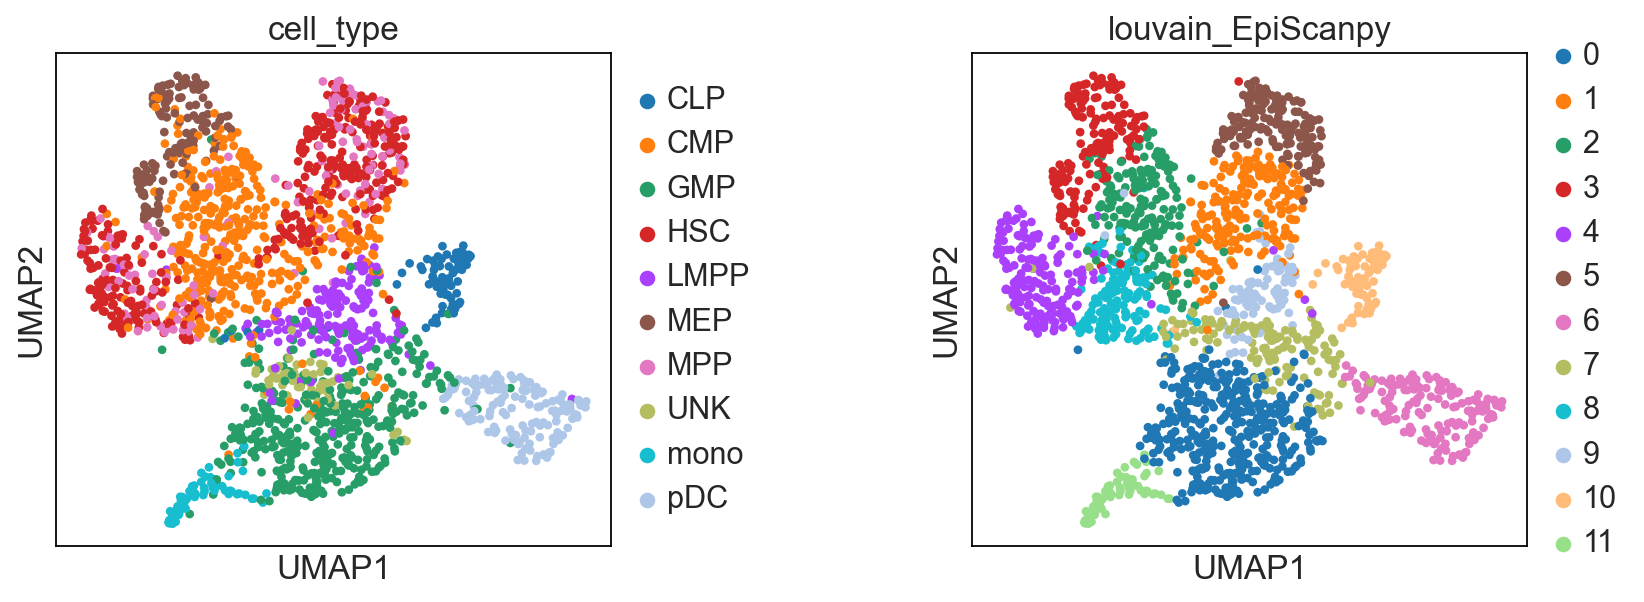

In [27]:
if Use_EpiScanpy:
    epi.pp.pca(adata, n_comps=Number_of_PCs, random_state=Random_seed)
    adata_episcanpy = ad.AnnData(adata.obsm['X_pca'], obs=adata.obs)
    epi.pp.neighbors(adata_episcanpy, n_neighbors=Number_of_neighbors, method=Method_for_connectivity, 
                     metric=Distance_metric, random_state=Random_seed)
    if Visualization_method == 'tsne':
        epi.tl.tsne(adata_episcanpy, perplexity=Perplexity, random_state=Random_seed)
    else:
        epi.tl.umap(adata_episcanpy, min_dist=Minimum_distance, random_state=Random_seed)
        
    epi_cluster(adata_episcanpy, use_method='EpiScanpy', cluster_method=Clustering_algorithm, n_cluster=Number_of_clusters, 
            resolution=Cluster_resolution, random_state=Random_seed)
    print(adata_episcanpy)
    sc.settings.set_figure_params(facecolor='white',figsize=(4,4),frameon=True,fontsize=15)
    if Cell_type_key is not None:
        if Visualization_method == 'tsne':
            epi.pl.tsne(adata_episcanpy, color=[Cell_type_key, Clustering_algorithm+'_EpiScanpy'], wspace=0.5)
        else:
            epi.pl.umap(adata_episcanpy, color=[Cell_type_key, Clustering_algorithm+'_EpiScanpy'], wspace=0.5)
    else:
        if Visualization_method == 'tsne':
            epi.pl.tsne(adata_episcanpy, color=[Clustering_algorithm+'_EpiScanpy'], wspace=0.5)
        else:
            epi.pl.umap(adata_episcanpy, color=[Clustering_algorithm+'_EpiScanpy'], wspace=0.5)

## 4.2 Signac
Perform the dimensionality reduction using Signac.  

User-defined parameters:  
Reference_genome - 'hg19', 'hg38', 'mm10' or 'mm9' are the 4 currently recognised genomic version in this pipeline. Default: None.

In [28]:
Reference_genome = 'hg19'

Attaching SeuratObject
载入需要的程辑包：stats4
载入需要的程辑包：BiocGenerics

载入程辑包：‘BiocGenerics’

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min

载入需要的程辑包：S4Vectors

载入程辑包：‘S4Vectors’

The following objects are masked from ‘package:base’:

    expand.grid, I, unname

载入需要的程辑包：IRanges
载入需要的程辑包：GenomeInfoDb

载入程辑包：‘Matrix’

The following object is masked from ‘package:S4Vectors’:

    expand


载入程辑包：‘data.table’

The following object is masked from ‘package:GenomicRanges’:

    shift

The following object is masked fr

[1] "Setting paramaters..."
[1] "=========================="
Task id =  Example 
The number of dimensions after reduction =  50 
Reference genome =  hg19 
[1] "=========================="
[1] "Loading data..."
[1] "Creating Signac object..."


[1] "Performing dimensionality reduction..."


Running SVD
Scaling cell embeddings
Done!


[1] "Saving results..."
AnnData object with n_obs × n_vars = 1945 × 50
    obs: 'batch', 'cell_name', 'cell_type', 'nb_features', 'log_nb_features', 'louvain_Signac'
    uns: 'neighbors', 'umap', 'louvain'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'


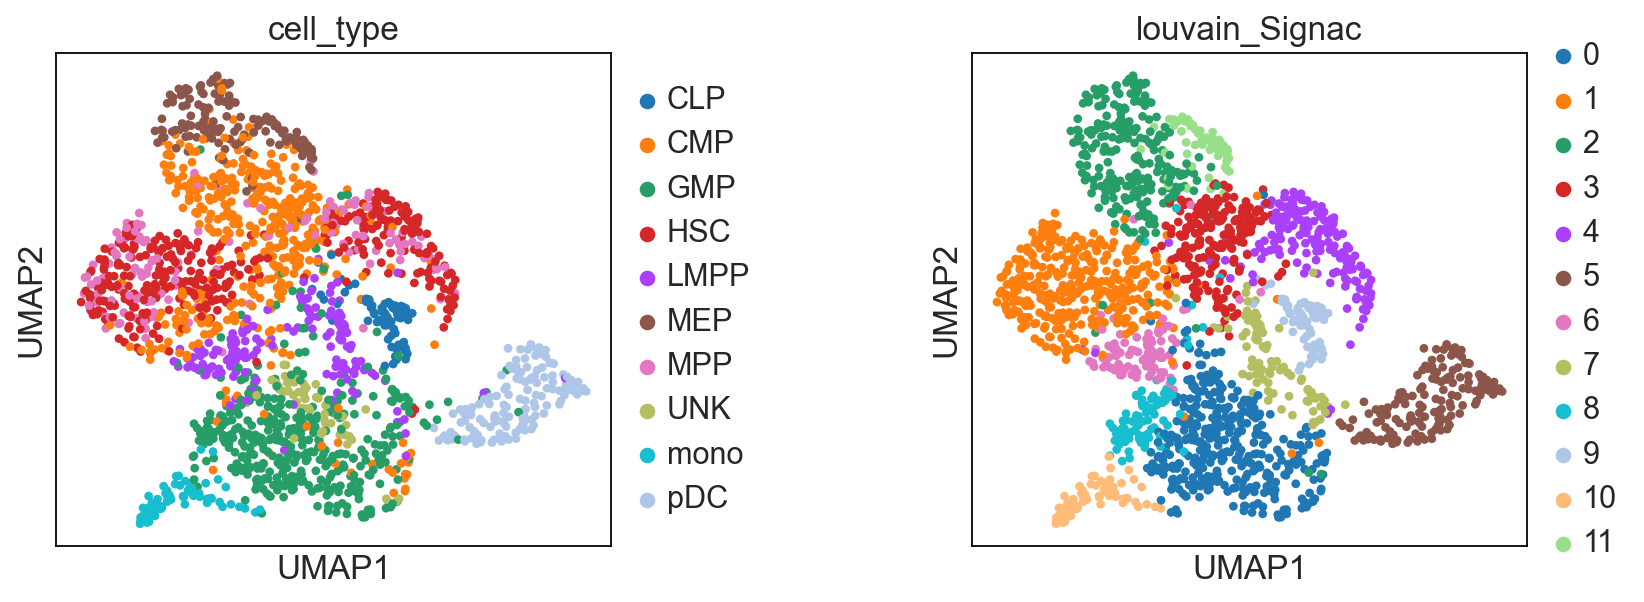

In [30]:
if Use_Signac:
    os.system(f'/home/scepitools/miniconda3/envs/signac/bin/Rscript scEpiEnsemble_Signac.R {task_id} {Number_of_PCs} {Reference_genome}')
    signac_embeddings = np.array(pd.read_table(Dir_intermediate + "%s_Signac.csv" % task_id).values)
    adata_signac = ad.AnnData(signac_embeddings, obs=adata.obs)
    epi.pp.neighbors(adata_signac, n_neighbors=Number_of_neighbors, method=Method_for_connectivity, 
                     metric=Distance_metric, random_state=Random_seed)
    if Visualization_method == 'tsne':
        epi.tl.tsne(adata_signac, perplexity=Perplexity, random_state=Random_seed)
    else:
        epi.tl.umap(adata_signac, min_dist=Minimum_distance, random_state=Random_seed)
    
    epi_cluster(adata_signac, use_method='Signac', cluster_method=Clustering_algorithm, n_cluster=Number_of_clusters, 
            resolution=Cluster_resolution, random_state=Random_seed)      
    print(adata_signac)
    sc.settings.set_figure_params(facecolor='white',figsize=(4,4),frameon=True,fontsize=15)
    if Cell_type_key is not None:
        if Visualization_method == 'tsne':
            epi.pl.tsne(adata_signac, color=[Cell_type_key, Clustering_algorithm+'_Signac'], wspace=0.5)
        else:
            epi.pl.umap(adata_signac, color=[Cell_type_key, Clustering_algorithm+'_Signac'], wspace=0.5)
    else:
        if Visualization_method == 'tsne':
            epi.pl.tsne(adata_signac, color=[Clustering_algorithm+'_Signac'], wspace=0.5)
        else:
            epi.pl.umap(adata_signac, color=[Clustering_algorithm+'_Signac'], wspace=0.5)

## 4.3 SnapATAC
Perform the dimensionality reduction using SnapATAC.  

载入需要的程辑包：Matrix
载入需要的程辑包：rhdf5
载入需要的程辑包：stats4
载入需要的程辑包：BiocGenerics

载入程辑包：‘BiocGenerics’

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min

载入需要的程辑包：S4Vectors

载入程辑包：‘S4Vectors’

The following objects are masked from ‘package:Matrix’:

    expand, unname

The following objects are masked from ‘package:base’:

    expand.grid, I, unname

载入需要的程辑包：IRanges
载入需要的程辑包：GenomeInfoDb

载入程辑包：‘data.table’

The following object is masked from ‘package:GenomicRanges’:

    shift

The following object is masked from

[1] "Setting paramaters..."
[1] "=========================="
Task id =  Example 
The number of dimensions after reduction =  50 
[1] "=========================="
[1] "Loading data..."
[1] "Creating SnapATAC object..."
number of barcodes: 1945
number of bins: 134919
number of genes: 0
number of peaks: 0
number of motifs: 0
[1] "Performing dimensionality reduction..."
[1] "Saving results..."


Done!


AnnData object with n_obs × n_vars = 1945 × 50
    obs: 'batch', 'cell_name', 'cell_type', 'nb_features', 'log_nb_features', 'louvain_SnapATAC'
    uns: 'neighbors', 'umap', 'louvain'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'


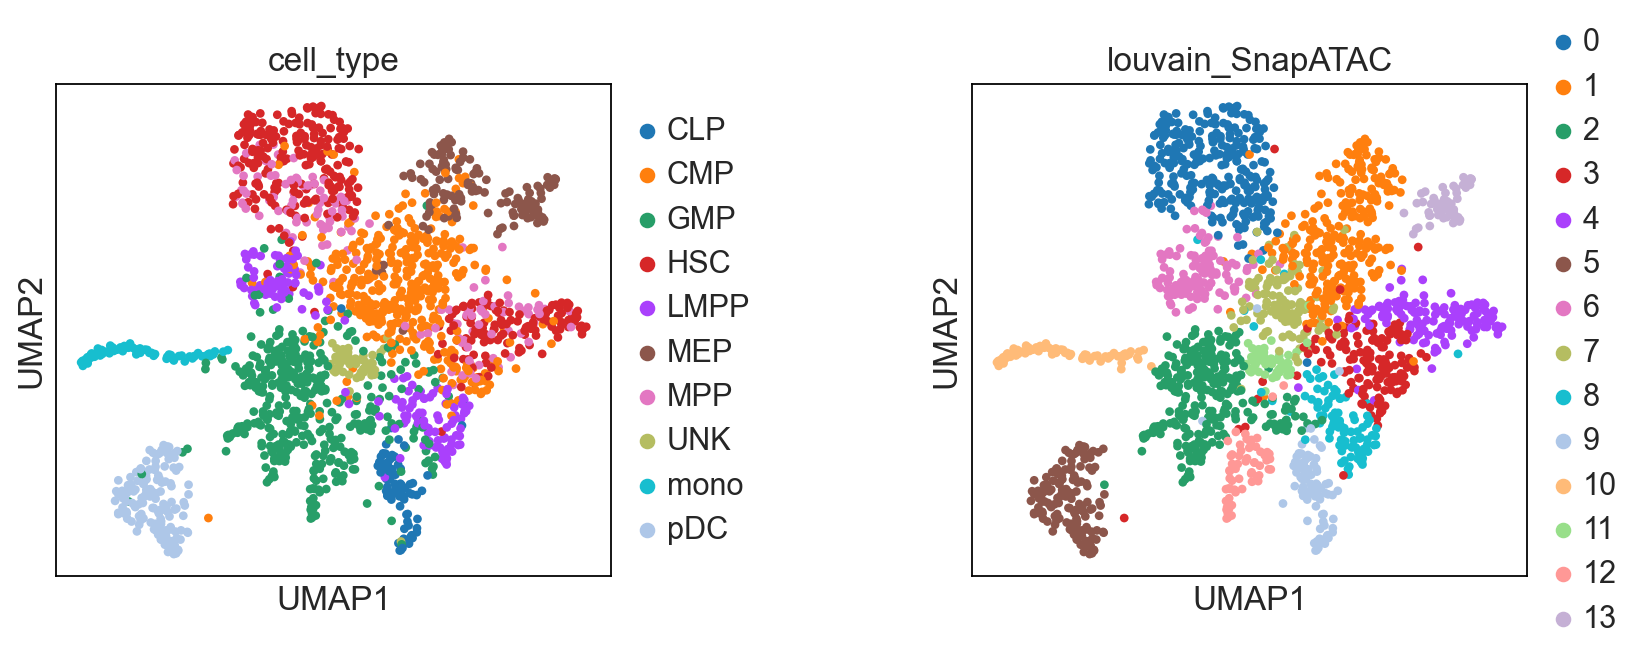

In [31]:
if Use_SnapATAC:
    os.system(f'/home/scepitools/miniconda3/envs/snapatac/bin/Rscript scEpiEnsemble_SnapATAC.R {task_id} {Number_of_PCs}')
    snapatac_embeddings = np.array(pd.read_table(Dir_intermediate + "%s_SnapATAC.csv" % task_id).values)
    adata_snapatac = ad.AnnData(snapatac_embeddings, obs=adata.obs)
    epi.pp.neighbors(adata_snapatac, n_neighbors=Number_of_neighbors, method=Method_for_connectivity, 
                     metric=Distance_metric, random_state=Random_seed)
    if Visualization_method == 'tsne':
        epi.tl.tsne(adata_snapatac, perplexity=Perplexity, random_state=Random_seed)
    else:
        epi.tl.umap(adata_snapatac, min_dist=Minimum_distance, random_state=Random_seed)
    
    epi_cluster(adata_snapatac, use_method='SnapATAC', cluster_method=Clustering_algorithm, n_cluster=Number_of_clusters, 
            resolution=Cluster_resolution, random_state=Random_seed)
    print(adata_snapatac)
    sc.settings.set_figure_params(facecolor='white',figsize=(4,4),frameon=True,fontsize=15)
    if Cell_type_key is not None:
        if Visualization_method == 'tsne':
            epi.pl.tsne(adata_snapatac, color=[Cell_type_key, Clustering_algorithm+'_SnapATAC'], wspace=0.5)
        else:
            epi.pl.umap(adata_snapatac, color=[Cell_type_key, Clustering_algorithm+'_SnapATAC'], wspace=0.5)
    else:
        if Visualization_method == 'tsne':
            epi.pl.tsne(adata_snapatac, color=[Clustering_algorithm+'_SnapATAC'], wspace=0.5)
        else:
            epi.pl.umap(adata_snapatac, color=[Clustering_algorithm+'_SnapATAC'], wspace=0.5)

## 4.4 ScEpiEnsemble
ScEpiEnsemble performs the dimensionality reduction by ensembling the results of EpiScanpy, Signac and SnapATAC.  

User-defined parameters:  
Ensemble_method - Ensemble method for integrating the results of selected kernels. Options are 'raw', 'minmax', 'z-score'. Default: 'z-score'.  
- raw: Ensemble the results of selected kernels by concatenating the latent features directly.  
- minmax: Ensemble the results of selected kernels by concatenating the latent features after a min-max normalization.  
- z-score: Ensemble the results of selected kernels by concatenating the latent features after a z-score normalization.  

In [32]:
Ensemble_method = 'z-score'
latents = []
if Ensemble_method == 'raw':
    if Use_EpiScanpy:
        latents = np.concatenate((latents, adata_episcanpy.X), axis=-1) if len(latents) != 0 else adata_episcanpy.X.copy()
    if Use_Signac:
        latents = np.concatenate((latents, adata_signac.X), axis=-1) if len(latents) != 0 else adata_signac.X.copy()
    if Use_SnapATAC:
        latents = np.concatenate((latents, adata_snapatac.X), axis=-1) if len(latents) != 0 else adata_snapatac.X.copy()
elif Ensemble_method == 'minmax':
    if Use_EpiScanpy:
        scale_embeddings = (adata_episcanpy.X - np.min(adata_episcanpy.X)) / (np.max(adata_episcanpy.X) - np.min(adata_episcanpy.X))
        latents = np.concatenate((latents, scale_embeddings), axis=-1) if len(latents) != 0 else scale_embeddings.copy()
    if Use_Signac:
        scale_embeddings = (adata_signac.X - np.min(adata_signac.X)) / (np.max(adata_signac.X) - np.min(adata_signac.X))
        latents = np.concatenate((latents, scale_embeddings), axis=-1) if len(latents) != 0 else scale_embeddings.copy()
    if Use_SnapATAC:
        scale_embeddings = (adata_snapatac.X - np.min(adata_snapatac.X)) / (np.max(adata_snapatac.X) - np.min(adata_snapatac.X))
        latents = np.concatenate((latents, scale_embeddings), axis=-1) if len(latents) != 0 else scale_embeddings.copy()
elif Ensemble_method == 'z-score':
    if Use_EpiScanpy:
        scale_embeddings = (adata_episcanpy.X - np.mean(adata_episcanpy.X)) / np.std(adata_episcanpy.X)
        latents = np.concatenate((latents, scale_embeddings), axis=-1) if len(latents) != 0 else scale_embeddings.copy()
    if Use_Signac:
        scale_embeddings = (adata_signac.X - np.mean(adata_signac.X)) / np.std(adata_signac.X)
        latents = np.concatenate((latents, scale_embeddings), axis=-1) if len(latents) != 0 else scale_embeddings.copy()
    if Use_SnapATAC:
        scale_embeddings = (adata_snapatac.X - np.mean(adata_snapatac.X)) / np.std(adata_snapatac.X)
        latents = np.concatenate((latents, scale_embeddings), axis=-1) if len(latents) != 0 else scale_embeddings.copy()
else:
    print("Ensemble method error!")

adata_scepiensemble = ad.AnnData(latents, obs=adata.obs)
epi.pp.neighbors(adata_scepiensemble, n_neighbors=Number_of_neighbors, method=Method_for_connectivity, 
                 metric=Distance_metric, random_state=Random_seed, use_rep='X')
if Visualization_method == 'tsne':
    epi.tl.tsne(adata_scepiensemble, perplexity=Perplexity, random_state=Random_seed)
else:
    epi.tl.umap(adata_scepiensemble, min_dist=Minimum_distance, random_state=Random_seed)

epi_cluster(adata_scepiensemble, use_method='scEpiEnsemble', cluster_method=Clustering_algorithm, n_cluster=Number_of_clusters, 
        resolution=Cluster_resolution, random_state=Random_seed)
print(adata_scepiensemble)

AnnData object with n_obs × n_vars = 1945 × 150
    obs: 'batch', 'cell_name', 'cell_type', 'nb_features', 'log_nb_features', 'louvain_scEpiEnsemble'
    uns: 'neighbors', 'umap', 'louvain'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'


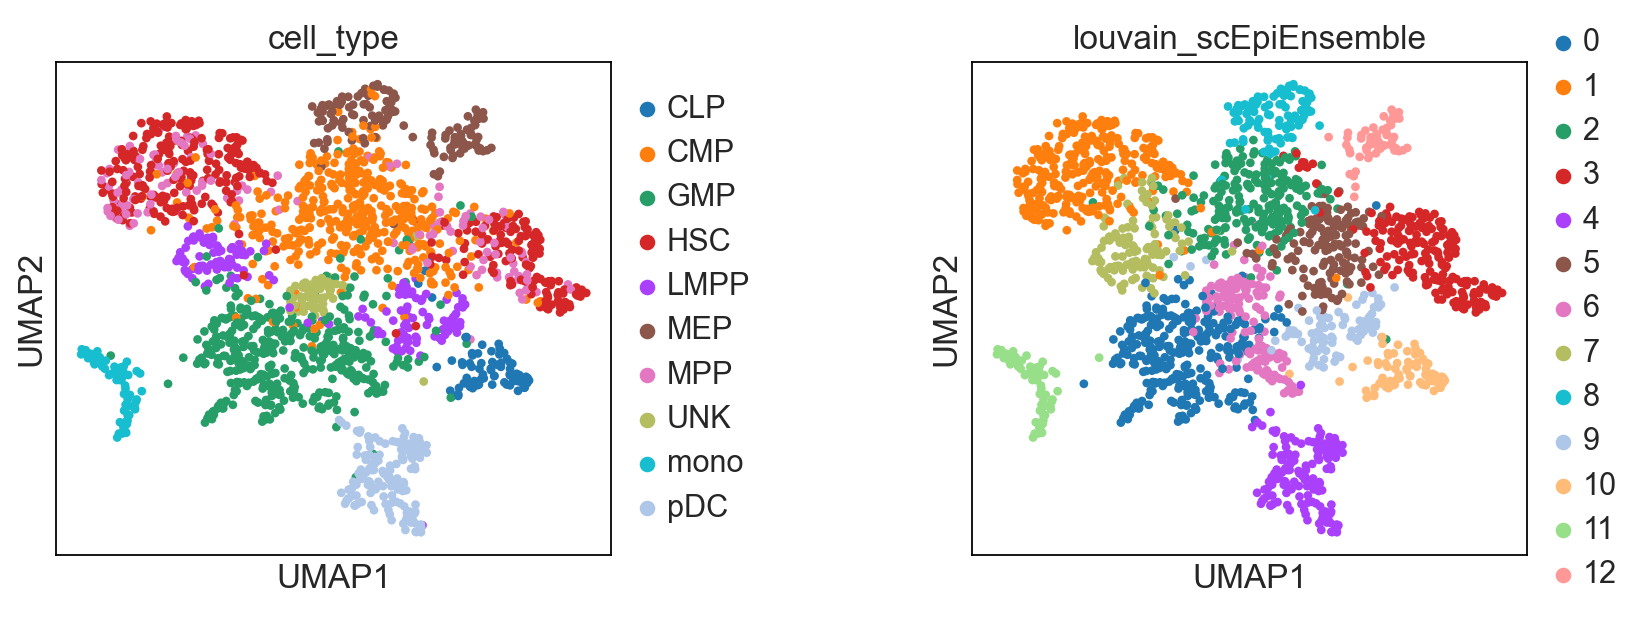

In [33]:
sc.settings.set_figure_params(facecolor='white',figsize=(4,4),frameon=True,fontsize=15)
if Cell_type_key is not None:
    if Visualization_method == 'tsne':
        epi.pl.tsne(adata_scepiensemble, color=[Cell_type_key, Clustering_algorithm+'_scEpiEnsemble'], wspace=0.5)
    else:
        epi.pl.umap(adata_scepiensemble, color=[Cell_type_key, Clustering_algorithm+'_scEpiEnsemble'], wspace=0.5)
else:
    if Visualization_method == 'tsne':
        epi.pl.tsne(adata_scepiensemble, color=[Clustering_algorithm+'_scEpiEnsemble'], wspace=0.5)
    else:
        epi.pl.umap(adata_scepiensemble, color=[Clustering_algorithm+'_scEpiEnsemble'], wspace=0.5)

# 5 Clustering performance
Calculate and compare clustering performance for scEpiEnsemble and other baseline methods.

In [34]:
def cluster_eval(adata, label_key, cluster_method, method, res_table_pd):
    cluster_key = cluster_method + '_' + method
    print(cluster_key)
    ARI = epi.tl.ARI(adata, label_key, cluster_key)
    AMI = epi.tl.AMI(adata, label_key, cluster_key)
    NMI = metrics.normalized_mutual_info_score(adata.obs[label_key], adata.obs[cluster_key])
    Homo = metrics.homogeneity_score(adata.obs[label_key], adata.obs[cluster_key])
    print('AMI:%.3f\tARI:%.3f\tNMI:%.3f\tHomo:%.3f'%(AMI,ARI,NMI,Homo))
    
    res_table_pd = res_table_pd.append(pd.DataFrame({'method':[method]*4, 'cluster_method':[cluster_method]*4, 
                                  'metric':['ARI','AMI','NMI','Homo'], 'value':[ARI,AMI,NMI,Homo]}), ignore_index=True)

    return res_table_pd

In [35]:
if Cell_type_key is not None:
    res_table_pd = pd.DataFrame(columns=['method', 'cluster_key', 'metric', 'value'])
    if Use_EpiScanpy:
        res_table_pd = cluster_eval(adata_episcanpy, Cell_type_key, Clustering_algorithm, 'EpiScanpy', res_table_pd)
    if Use_Signac:
        res_table_pd = cluster_eval(adata_signac, Cell_type_key, Clustering_algorithm, 'Signac', res_table_pd)
    if Use_SnapATAC:
        res_table_pd = cluster_eval(adata_snapatac, Cell_type_key, Clustering_algorithm, 'SnapATAC', res_table_pd)
    res_table_pd = cluster_eval(adata_scepiensemble, Cell_type_key, Clustering_algorithm, 'scEpiEnsemble', res_table_pd)

louvain_EpiScanpy
AMI:0.615	ARI:0.445	NMI:0.619	V-measure:0.619
louvain_Signac
AMI:0.575	ARI:0.392	NMI:0.580	V-measure:0.580
louvain_SnapATAC
AMI:0.622	ARI:0.448	NMI:0.627	V-measure:0.627
louvain_scEpiEnsemble
AMI:0.641	ARI:0.483	NMI:0.645	V-measure:0.645


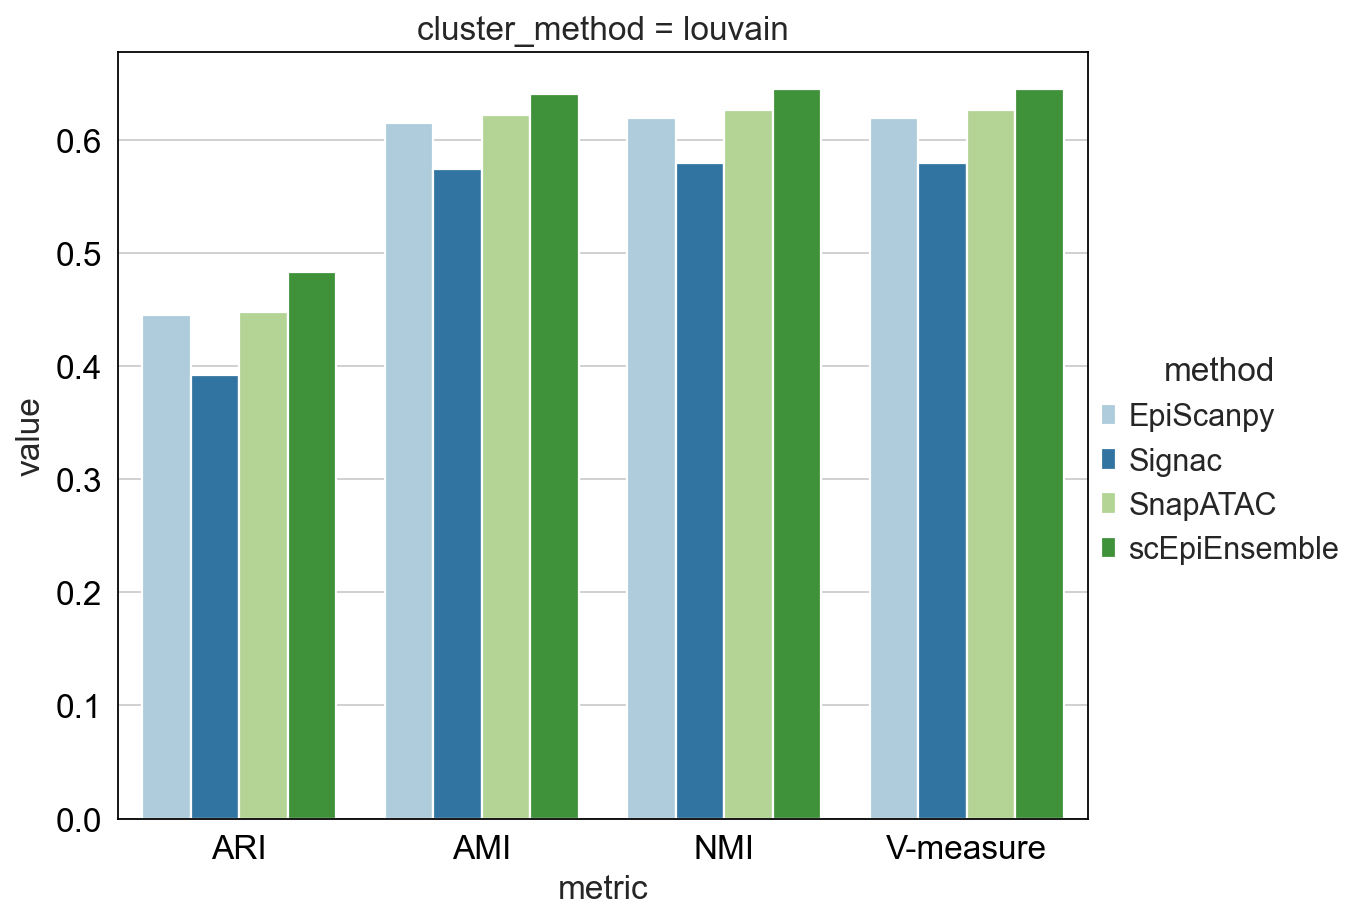

In [36]:
sc.settings.set_figure_params(dpi=80,facecolor='white',figsize=(14,12),frameon=True,fontsize=15)
g = sns.catplot(col='cluster_method', x="metric", y="value", hue="method", data=res_table_pd,
            palette='Paired', kind="bar", height=6, aspect=1.2, sharey=False, col_wrap=1)
sns.despine(top=False, right=False)

# 6 Save h5ad
Write .h5ad-formatted hdf5 file. You can get the results (a html file, a h5ad file and figure files) via your taskID. 

In [37]:
adata.obsm['scEpiEnsemble'] = adata_scepiensemble.X.copy()
adata.obsm['EpiScanpy'] = adata_episcanpy.X.copy()
adata.obsm['Signac'] = adata_signac.X.copy()
adata.obsm['SnapATAC'] = adata_snapatac.X.copy()
print(adata)

AnnData object with n_obs × n_vars = 1945 × 134919
    obs: 'batch', 'cell_name', 'cell_type', 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness'
    uns: 'pca'
    obsm: 'X_pca', 'scEpiEnsemble', 'EpiScanpy', 'Signac', 'SnapATAC'
    varm: 'PCs'
    layers: 'normalised'


In [38]:
adata.write(outputpath+'results/%s_result.h5ad.gz'%task_id, compression='gzip')